# **Reconnaissance des plaques d'immatriculation à l'aide de YoLo et DarkNet**

<img src='https://betterdatascience.com/detect-license-plates-with-yolo/images/1.jpg'>



# **Darknet :**

<img src='https://miro.medium.com/v2/resize:fit:512/0*GFsAY18k3A25IpRL'>

- Darknet est un framework de réseau de neurones développé par Joseph Chet Redom. 
- Il s'agit essentiellement de nous fournir à tous un terrain de jeu pour construire nos propres modèles de réseaux de neurones. 
- Ce framework est écrit en « C » et « CUDA ». 
- Il est rapide et prend en charge les calculs CPU et GPU. 
-  Ce framework dépend des packages OpenCV et CUDA. Il prend en charge une large gamme de modèles tels que YOLO, RNN, etc. 
- Pour plus d'informations sur Darknet, vous pouvez visiter ce site Web https://pjreddie.com/darknet/ .

# **YOLO _ V3 :**

- YOLO signifie Y ou O nly L ook O nce. C'est l'un des algorithmes avancés actuels lorsque vous avez besoin d'une détection en temps réel (en millisecondes) de la classe et de la prédiction de la classe de cet objet détecté. 
- D'autre part, ce n'est pas l'algorithme le plus précis, mais c'est le meilleur des modèles de détection précis en temps réel.
- Avant la version, nous avions les modèles yolo_v1 et yolo_v2. vous pouvez obtenir plus de détails dans leurs documents officiels publiés. yolo_v1 et yolo_v2 .

- J'essaie d'expliquer un peu l'architecture v3. Il a un total de 106 couches. - Le meilleur avantage de ce modèle est qu'il fait des prédictions à trois échelles ( à la couche - 82 , 94 , 106 ). 
- Et en même temps, les images seront sous-échantillonnées leurs dimensions à 52 X 52 , 26X26 , 13X13 respectivement dans ces couches. Peu d'avantages sont

1 . 
- Les caractéristiques sont détectées en multi-échelle (52 x 52 , 26 x 26 , 13x13 ).

2. Réseau d'extracteurs de fonctionnalités plus puissant

3. Fonction de perte optimisée

- L'image suivante vous donne un aperçu plus détaillé de toutes les couches.



<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*3v10JDBF-1CApcQV.png'>

- À haut niveau, les couches ci-dessus peuvent être divisées en deux catégories principales - Feature Extractor et Detector. 
- Lorsqu'une nouvelle image arrive dans le réseau, elle passe d'abord par l'extracteur de caractéristiques (les caractéristiques sortiront à trois étapes différentes à trois échelles différentes), puis ces caractéristiques sont introduites dans la branche du détecteur pour détecter les boîtes englobantes autour des objets détectés et enfin ces boîtes englobantes seront classées dans l'une des catégories.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*RTdjlhEkAsFBMsU4.jpeg'>

# **Extracteur de fonctionnalités :**

- La fonctionnalité extracor dans YOLO V3 (également appelée Darknet -53) comporte elle-même 53 couches distinctes (sur un total de 106 couches). 
- Ces 53 couches de Darknet peuvent être expliquées avec le tableau suivant.
<img src='https://miro.medium.com/v2/resize:fit:640/format:webp/0*lKqQiOgaDBjpjcZo.jpeg'>

- L'ensemble total du cadre peut être divisé en petits blocs indépendants qui sont connectés avec une couche de 2 convolutions. 
- Nous pouvons directement convertir cet extracteur de caractéristiques en classificateur en ajoutant trois couches distinctes (Avg-pool Connected et Soft-max). 
- Mais dans notre application de détection d'objets, nous utilisons ce Darknet-53 comme seul extracteur de fonctionnalités et est connecté à un bloc de couches de détection. 
- Nous n'inclurons donc pas les trois dernières couches dans notre modèle.

- À partir de cet extracteur de caractéristiques, si nous insérons une image, cela donnera trois vecteurs de caractéristiques à différentes étapes du flux de réseau. 
- Ces trois fonctionnalités seront insérées séparément dans le bloc Détecteur.

## **Importer la data depuis Kaggle**

In [1]:
!pip install -q kaggle

In [7]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d elysian01/car-number-plate-detection

100% 2.69G/2.69G [01:40<00:00, 33.2MB/s]
100% 2.69G/2.69G [01:40<00:00, 28.8MB/s]


In [10]:
!kaggle datasets download -d achrafkhazri/yolo-weights-for-licence-plate-detector

 99% 216M/218M [00:08<00:00, 24.3MB/s]
100% 218M/218M [00:08<00:00, 25.6MB/s]


## **Importer les Bibliothèques**

In [11]:
import numpy as np
import pandas as pd
import os
import cv2
import time
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import zipfile

## **Extraction des fichiers ZIP**

In [12]:
# Spécifiez le chemin du fichier ZIP
zip_file_path = '/content/car-number-plate-detection.zip'
# Spécifiez le répertoire où vous souhaitez extraire les fichiers
extract_directory = '/content/car-number-plate-detection'
# Ouvrez le fichier ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extrayez tous les contenus du fichier ZIP dans le répertoire spécifié
    zip_ref.extractall(extract_directory)
print("Extraction terminée.")

Unzipping complete.


In [13]:
# Spécifiez le chemin du fichier ZIP
zip_file_path = '/content/yolo-weights-for-licence-plate-detector.zip'
# Spécifiez le répertoire où vous souhaitez extraire les fichiers
extract_directory = '/content/yolo-weights-for-licence-plate-detector'
# Ouvrez le fichier ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extrayez tous les contenus du fichier ZIP dans le répertoire spécifié
    zip_ref.extractall(extract_directory)
print("Unzipping complete.")

Unzipping complete.


## **Parcours récursif d'un répertoire et récupération des chemins de fichiers**

In [14]:
import os

# Liste pour stocker les chemins des fichiers
paths = []

# Parcourir récursivement le répertoire '/content/car-number-plate-detection/Car_Number_Plate'
# et récupérer les chemins de tous les fichiers
for dirname, _, filenames in os.walk('/content/car-number-plate-detection/Car_Number_Plate'):
    for filename in filenames:
        # Ajouter le chemin complet du fichier à la liste des chemins
        paths.append(os.path.join(dirname, filename))

In [15]:
n=len(paths)
N=6

In [17]:
labels = open('/content/yolo-weights-for-licence-plate-detector/classes.names').read()

In [18]:
# Chemin vers les poids du modèle YOLO
weights_path = '/content/yolo-weights-for-licence-plate-detector/lapi.weights'
# Chemin vers la configuration du modèle YOLO
configuration_path = '/content/yolo-weights-for-licence-plate-detector/darknet-yolov3.cfg'
# Probabilité minimum pour filtrer les détections
probability_minimum = 0.4
# Seuil pour la suppression des détections faibles
threshold = 0.3

## **Configuration du modèle YOLO et paramètres de détection**

In [21]:
# Charger le modèle Darknet à partir de la configuration et des poids
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

# Récupérer les noms de toutes les couches du réseau
layers_names_all = network.getLayerNames()

# Récupérer les indices des couches de sortie non connectées
layers_indices_output = network.getUnconnectedOutLayers()

# Vérifier si layers_indices_output est un entier
if isinstance(layers_indices_output, int):
    # Convertir en liste
    layers_indices_output = [layers_indices_output]

# Récupérer les noms des couches de sortie à partir des indices
layers_names_output = [layers_names_all[i - 1] for i in layers_indices_output]

## **Chargement et affichage de l'image**

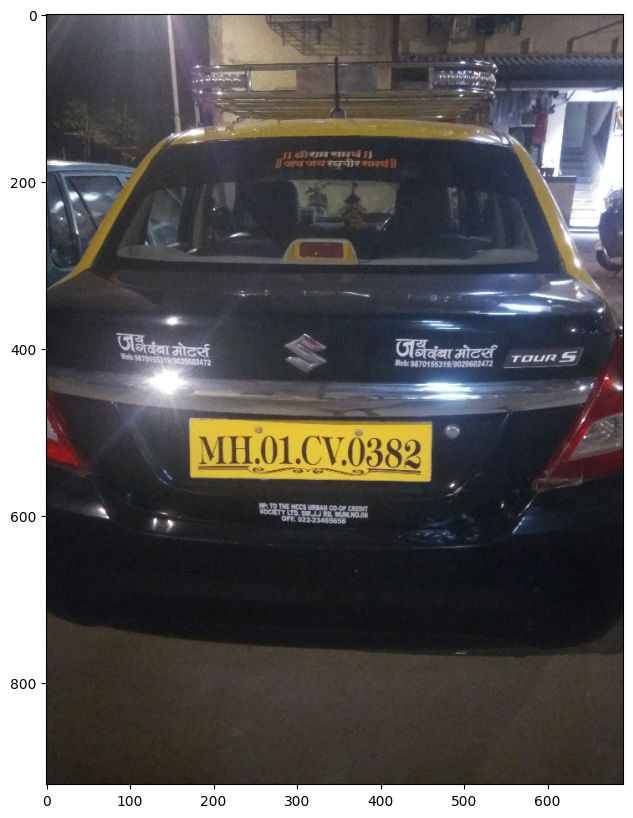

In [22]:
# Lire l'image à partir du chemin spécifié
image_input = cv2.imread(paths[N])

# Redimensionner l'image en utilisant un facteur de réduction de 0.2
image_input = cv2.resize(image_input, dsize=None, fx=0.2, fy=0.2)

# Afficher l'image en utilisant Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Configurer la taille de la figure
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Afficher l'image convertie en espace de couleur RGB
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()


## **Préparation de l'image pour la détection avec YOLO**

**Exercice : Convertir une image en blob d'entrée pour le réseau YOLO**

- Dans cet exercice, nous allons convertir une image en un blob d'entrée pour le réseau YOLO en utilisant OpenCV. 
- Le blob d'entrée est une représentation prétraitée de l'image qui peut être utilisée pour effectuer des prédictions d'objets avec le réseau YOLO.

- Voici le code à compléter :

In [23]:
import cv2
import numpy as np
# Lire l'image à partir du chemin spécifié
image_input = cv2.imread("chemin/vers/l/image.jpg")
# Convertir l'image en un blob d'entrée pour le réseau YOLO
blob = cv2.dnn.blobFromImage(#fill_here, #fill_here, #fill_here, #fill_here, #fill_here)
# Réorganiser les dimensions du blob pour l'affichage
blob_to_show = blob[0,:,:,:].transpose(#fill_here)
# Définir le blob en tant qu'entrée pour le réseau
network.setInput(#fill_here)
# Obtenir les sorties du réseau pour les couches de sortie spécifiées
output_from_network = network.forward(#fill_here)
# Générer des couleurs aléatoires pour chaque étiquette de classe
np.random.seed(42)
colours = np.random.randint(#fill_here, #fill_here, size=(#fill_here, #fill_here), dtype='uint8')


**Instructions :**
1.  Utilisez la méthode cv2.dnn.blobFromImage() pour convertir l'image en un blob d'entrée pour le réseau YOLO. Utilisez les arguments appropriés pour effectuer la conversion. Le facteur d'échelle (scalefactor) est 1/255.0, la taille du blob (size) est (416, 416), swapRB est True et crop est False. Assignez le résultat à la variable blob.
2.  Réorganisez les dimensions du blob pour l'affichage en utilisant la méthode transpose() de l'objet blob. Les axes à transposer sont 0, 1 et 2, dans cet ordre. Assignez le résultat à la variable blob_to_show.
3.  Définissez le blob en tant qu'entrée pour le réseau en utilisant la méthode setInput() de l'objet network. Passez le blob en tant qu'argument.
4.  Obtenez les sorties du réseau pour les couches de sortie spécifiées en utilisant la méthode forward() de l'objet network. Passez les noms des couches de sortie (layers_names_output) en tant qu'argument. Assignez le résultat à la variable output_from_network.
5.  Générez des couleurs aléatoires pour chaque étiquette de classe en utilisant la méthode random.randint() de l'objet np. Les arguments pour randint() sont la valeur minimale (low), la valeur maximale (high), la taille (size) de la matrice de couleurs et le type de données (dtype) en tant que 'uint8'. Utilisez np.random.seed(42) pour fixer la graine aléatoire. 

## **Détection d'objets avec YOLO et récupération des résultats**

**Exercice : Traitement des résultats de détection avec YOLO**

- Dans cet exercice, nous allons traiter les résultats de détection obtenus à partir du réseau YOLO. 
- Nous allons extraire les boîtes englobantes, les confiances et les numéros de classe associés à chaque détection.

In [24]:
import numpy as np

# Listes pour stocker les boîtes englobantes, les confiances et les numéros de classe
bounding_boxes = []
confidences = []
class_numbers = []

# Récupérer les dimensions de l'image
h, w = image_input.shape[:2]

# Parcourir les résultats de la sortie du réseau
for result in output_from_network:
    # Parcourir les détections dans chaque résultat
    for detection in result:
        # Récupérer les scores de confiance pour chaque classe
        scores = detection[#fill_here_:]

        # Trouver l'indice de classe avec la plus haute probabilité
        class_current =#fill_here

        # Récupérer la confiance pour la classe actuelle
        confidence_current = score[class_current]

        # Vérifier si la confiance dépasse le seuil minimum
        if #fill_here:
            # Récupérer les coordonnées de la boîte englobante et les ajuster à la taille de l'image originale
            box_current = detection[#fill_here:#fill_here] * np.array([w, h, w, h])
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(#fill_here)
            y_min = int(#fill_here)

            # Ajouter la boîte englobante, la confiance et le numéro de classe aux listes correspondantes
            bounding_boxes.append([#fill_here, #fill_here, int(#fill_here), int(#fill_here)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)


**Instructions :**

- Créez les listes bounding_boxes, confidences et class_numbers pour stocker respectivement les boîtes englobantes, les confiances et les numéros de classe associés à chaque détection.
- Récupérez les dimensions de l'image en utilisant la méthode shape de l'objet image_input et assignez les valeurs aux variables h et w.
- Parcourez les résultats de la sortie du réseau en utilisant une boucle for avec la variable result.
- À l'intérieur de la boucle, parcourez les détections dans chaque résultat en utilisant une boucle for avec la variable detection.
- Récupérez les scores de confiance pour chaque classe en utilisant la notation de découpage ([5:]) sur la variable detection. Assignez les valeurs à la variable scores.
- Trouvez l'indice de classe avec la plus haute probabilité en utilisant np.argmax(scores). Assignez la valeur à la variable class_current.
- Récupérez la confiance pour la classe actuelle en utilisant l'indice class_current dans la variable scores. Assignez la valeur à la variable confidence_current.
- Complétez la condition if pour vérifier si la confidence_current est supérieure au seuil minimum probability_minimum.
- À l'intérieur de la condition, récupérez les coordonnées de la boîte englobante en utilisant la notation de découpage ([0:4]) sur la variable detection. Multipliez ensuite les coordonnées par un tableau de facteurs pour ajuster les coordonnées à la taille de l'image originale. Assignez les valeurs respectivement aux variables x_center, y_center, box_width et box_height.
- Calculez les valeurs x_min et y_min en utilisant les variables x_center, y_center, box_width et box_height.
- Ajoutez la boîte englobante à la liste bounding_boxes en utilisant la méthode append avec une liste contenant x_min, y_min, int(box_width) et int(box_height).
- Ajoutez la confiance à la liste confidences en utilisant la méthode append avec la valeur float(confidence_current).
- Ajoutez le numéro de classe à la liste class_numbers en utilisant la méthode append avec la valeur class_current.

## **Suppression des détections redondantes avec la suppression non maximale (NMS)**

In [25]:
# Supprimer les détections redondantes à l'aide de la suppression non maximale (NMS)
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Vérifier s'il y a des résultats après la suppression non maximale
if len(results) > 0
    # Parcourir les résultats aplatis
    for i in results.flatten():
        # Récupérer les coordonnées et les dimensions de la boîte englobante
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
        
        # Récupérer la couleur de la boîte englobante pour la classe actuelle
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]
        
        # Dessiner la boîte englobante sur l'image d'entrée
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)
        
        # Ajouter le texte de la classe et de la confiance sur l'image d'entrée
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, colour_box_current, 5)


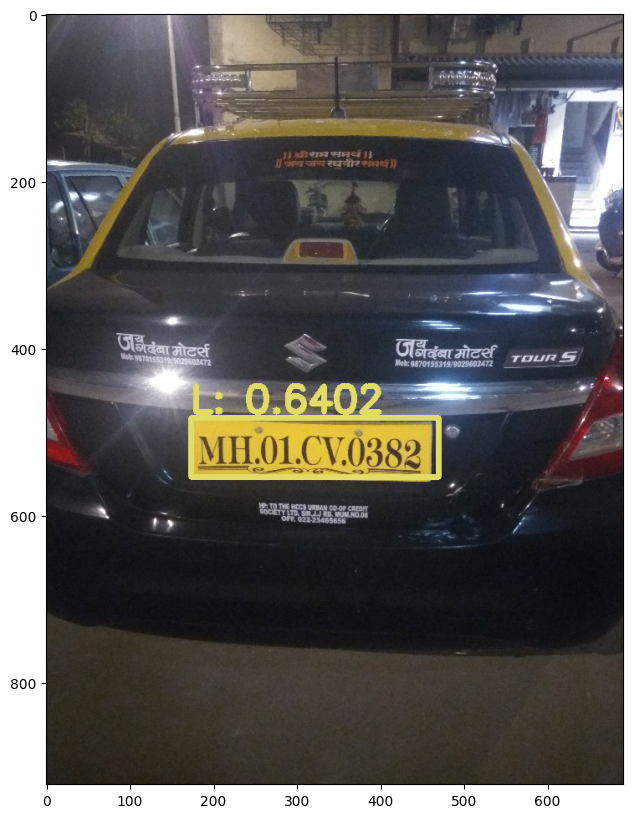

In [26]:
import matplotlib.pyplot as plt
# Configurer la taille de la figure
plt.rcParams['figure.figsize'] = (10.0, 10.0)
# Afficher l'image convertie en espace de couleur RGB
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()
